# Market Basket Analysis with Apriori Algorithm

This notebook implements the Apriori algorithm for market basket analysis with the UCI Online Retail dataset, which contains real transaction data from an online retailer.

## 1. Import Required Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import defaultdict, Counter
import random
import time
import networkx as nx



## 2. Load the UCI Online Retail Dataset

In [113]:
from ucimlrepo import fetch_ucirepo 

# Fetch UCI Online Retail dataset
online_retail = fetch_ucirepo(id=352) 

# Data (as pandas dataframes) 
retail_data = online_retail.data.original  # Use original data which contains all columns

# Display metadata and variables
print("Dataset metadata:")
print(online_retail.metadata) 
print("\nVariable information:")
print(online_retail.variables)

# Display a sample of the dataset
print("\nSample of the dataset:")
display(retail_data.head())

# Check column names 
print("\nColumns in the dataset:")
print(retail_data.columns.tolist())

Dataset metadata:
{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Columns in the dataset:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


## 3. Preprocess the Data

Let's preprocess the data to get it into the right format for the Apriori algorithm:
1. Clean the data by removing null values
2. Filter out cancelled transactions (those with InvoiceNo starting with 'C')
3. Group items by transaction (InvoiceNo)

In [114]:
# Data preprocessing
def preprocess_retail_data(df, country=None, max_transactions=None):
    """
    Preprocess the retail data for association rule mining
    
    Parameters:
    df: DataFrame with retail data
    country: Optional filter for specific country
    max_transactions: Maximum number of transactions to include
    
    Returns:
    transactions: List of sets where each set contains items in a transaction
    """
    print("Original data shape:", df.shape)
    
    # First check if the required columns exist
    required_cols = ['InvoiceNo', 'Description']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in dataframe. Available columns: {df.columns.tolist()}")
    
    # Remove missing values in key fields
    df = df.dropna(subset=['InvoiceNo', 'Description'])
    print("After removing nulls:", df.shape)
    
    # Filter out cancelled transactions (those with InvoiceNo starting with 'C')
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    print("After removing cancelled transactions:", df.shape)
    
    # Filter by country if specified
    if country and 'Country' in df.columns:
        df = df[df['Country'] == country]
        print(f"After filtering for {country}:", df.shape)
    
    # Remove rows with quantity <= 0 if Quantity column exists
    if 'Quantity' in df.columns:
        df = df[df['Quantity'] > 0]
        print("After removing non-positive quantities:", df.shape)
    
    # Get unique invoice numbers
    unique_invoices = df['InvoiceNo'].unique()
    
    # If max_transactions is specified, limit the number of invoice numbers
    if max_transactions and len(unique_invoices) > max_transactions:
        print(f"Limiting to {max_transactions} transactions")
        unique_invoices = unique_invoices[:max_transactions]
        df = df[df['InvoiceNo'].isin(unique_invoices)]
    
    # Convert to transaction format
    transactions = df.groupby('InvoiceNo')['Description'].apply(lambda x: set(x)).tolist()
    
    # If we have more than max_transactions, truncate the list
    if max_transactions and len(transactions) > max_transactions:
        transactions = transactions[:max_transactions]
    
    print(f"\nCreated {len(transactions)} transactions")
    print(f"Average items per transaction: {sum(len(t) for t in transactions) / len(transactions):.2f}")
    
    return transactions

# Create a synthetic dataset if UCI data doesn't work
def generate_synthetic_transactions(num_transactions=100):
    """Generate synthetic transactions if the UCI data loading fails"""
    print("Generating synthetic dataset of 100 transactions as a fallback")
    
    items = [
        'WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER',
        'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART', 'SET 7 BABUSHKA NESTING BOXES',
        'GLASS STAR FROSTED T-LIGHT HOLDER', 'HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT',
        "ASSORTED COLOUR BIRD ORNAMENT", "POPPY'S PLAYHOUSE BEDROOM", "POPPY'S PLAYHOUSE KITCHEN",
        "FELTCRAFT PRINCESS CHARLOTTE DOLL", "IVORY KNITTED MUG COSY", 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
        'BOX OF VINTAGE JIGSAW BLOCKS', 'BOX OF VINTAGE ALPHABET BLOCKS', 'HOME BUILDING BLOCK WORD',
        'LOVE BUILDING BLOCK WORD', 'RECIPE BOX WITH METAL HEART', 'DOORMAT NEW ENGLAND'
    ]
    
    transactions = []
    for _ in range(num_transactions):
        # Generate a transaction with 1-10 random items
        num_items = random.randint(1, 10)
        transaction = set(random.sample(items, min(num_items, len(items))))
        transactions.append(transaction)
    
    return transactions

# Try to preprocess the UCI data or fall back to synthetic data
try:
    # First check if InvoiceNo and Description columns exist
    if 'InvoiceNo' in retail_data.columns and 'Description' in retail_data.columns:
        transactions = preprocess_retail_data(retail_data, country='United Kingdom', max_transactions=100)
    else:
        print(f"Required columns not found. Available columns: {retail_data.columns.tolist()}")
        transactions = generate_synthetic_transactions(100)
except Exception as e:
    print(f"Error during preprocessing: {e}")
    transactions = generate_synthetic_transactions(100)

# Ensure we have exactly 100 transactions
if len(transactions) > 100:
    print("Trimming to exactly 100 transactions")
    transactions = transactions[:100]
elif len(transactions) < 100:
    print(f"Only {len(transactions)} transactions available, generating synthetic data to reach 100")
    additional_transactions = generate_synthetic_transactions(100 - len(transactions))
    transactions.extend(additional_transactions)

# Display a few sample transactions
print("\nSample transactions:")
for i, transaction in enumerate(transactions[:5]):
    display_items = list(transaction)[:5]
    if len(transaction) > 5:
        display_items.append("...")
    print(f"Transaction {i+1} ({len(transaction)} items): {display_items}")

# Verify we have exactly 100 transactions
print(f"\nTotal transactions: {len(transactions)}")
assert len(transactions) == 100, "Number of transactions should be exactly 100"

Original data shape: (541909, 8)
After removing nulls: (540455, 8)
After removing cancelled transactions: (531167, 8)
After filtering for United Kingdom: (486168, 8)
After removing non-positive quantities: (485694, 8)
Limiting to 100 transactions

Created 100 transactions
Average items per transaction: 20.47

Sample transactions:
Transaction 1 (7 items): ['GLASS STAR FROSTED T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'RED WOOLLY HOTTIE WHITE HEART.', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'SET 7 BABUSHKA NESTING BOXES', '...']
Transaction 2 (2 items): ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT']
Transaction 3 (12 items): ['BOX OF VINTAGE ALPHABET BLOCKS', 'HOME BUILDING BLOCK WORD', 'DOORMAT NEW ENGLAND', 'BOX OF 6 ASSORTED COLOUR TEASPOONS', 'LOVE BUILDING BLOCK WORD', '...']
Transaction 4 (4 items): ['RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION', 'BLUE COAT RACK PARIS FASHION', 'JAM MAKING SET WITH JARS']
Transaction 5 (1 items): ['BATH BUILDING BLOCK WORD']

## 4. Apriori Algorithm Implementation

In [115]:
class Apriori:
    def __init__(self, min_support=0.1, min_confidence=0.5):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.itemsets = {}
        self.rules = []
    
    def _get_support(self, itemset, transactions):
        """Calculate support for an itemset"""
        count = sum(1 for transaction in transactions if itemset.issubset(transaction))
        return count / len(transactions)
    
    def _generate_candidates(self, prev_itemsets, k):
        """Generate candidate itemsets of size k"""
        candidates = set()
        for i in prev_itemsets:
            for j in prev_itemsets:
                # Merge two itemsets if they share k-2 items
                union = i.union(j)
                if len(union) == k:
                    candidates.add(union)
        return candidates
    
    def fit(self, transactions):
        """Find frequent itemsets and generate association rules"""
        # Find frequent 1-itemsets
        items = set()
        for transaction in transactions:
            for item in transaction:
                items.add(frozenset([item]))
        
        # Calculate support for 1-itemsets
        self.itemsets[1] = {item: self._get_support(item, transactions) 
                           for item in items 
                           if self._get_support(item, transactions) >= self.min_support}
        
        # Find frequent k-itemsets for k >= 2
        k = 2
        while self.itemsets[k-1]:
            # Generate candidates
            candidates = self._generate_candidates(
                set(frozenset(itemset) for itemset in self.itemsets[k-1]),
                k
            )
            
            # Calculate support for candidates
            self.itemsets[k] = {itemset: self._get_support(itemset, transactions) 
                               for itemset in candidates 
                               if self._get_support(itemset, transactions) >= self.min_support}
            
            k += 1
        
        # Remove empty itemsets
        keys_to_remove = [k for k, v in self.itemsets.items() if not v]
        for k in keys_to_remove:
            del self.itemsets[k]
        
        # Generate association rules
        self._generate_rules(transactions)
        
        return self
    
    def _generate_rules(self, transactions):
        """Generate association rules from frequent itemsets"""
        for k in range(2, len(self.itemsets) + 1):
            for itemset in self.itemsets[k]:
                for i in range(1, k):
                    for antecedent in combinations(itemset, i):
                        antecedent = frozenset(antecedent)
                        consequent = itemset - antecedent
                        
                        # Calculate confidence
                        confidence = self.itemsets[k][itemset] / self.itemsets[len(antecedent)][antecedent]
                        
                        # Calculate lift
                        lift = confidence / self.itemsets[len(consequent)][consequent]
                        
                        if confidence >= self.min_confidence:
                            self.rules.append((antecedent, consequent, confidence, lift))
    
    def get_frequent_itemsets(self):
        """Return all frequent itemsets"""
        result = []
        for k, itemsets in self.itemsets.items():
            for itemset, support in itemsets.items():
                result.append((itemset, support))
        return result
    
    def get_rules(self):
        """Return all association rules"""
        return self.rules

## 5. Visualization Functions

In [116]:
def plot_item_frequency(transactions):
    """Plot the frequency of individual items in the dataset"""
    # Count item frequencies
    item_counts = Counter()
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1
    
    # Convert to DataFrame for plotting
    df = pd.DataFrame({
        'Item': list(item_counts.keys()),
        'Count': list(item_counts.values())
    }).sort_values('Count', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Count', y='Item', data=df.head(15), color='skyblue', edgecolor='black')
    
    # Add value labels to the bars
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 1, p.get_y() + p.get_height()/2, f'{int(width)}', 
                ha='left', va='center')
    
    plt.title('Top 15 Most Frequent Items', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Item', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return df

def plot_rule_confidence(rules):
    """Plot the confidence distribution of association rules"""
    # Extract confidence values
    confidences = [confidence for _, _, confidence, _ in rules]
    
    if not confidences:
        print("No rules found to display confidence distribution.")
        return
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(confidences, bins=min(20, len(confidences)), kde=True, color='skyblue', edgecolor='black')
    
    # Add a vertical line at the mean confidence
    mean_conf = sum(confidences) / len(confidences)
    plt.axvline(x=mean_conf, color='red', linestyle='--', linewidth=2)
    plt.text(mean_conf+0.01, plt.ylim()[1]*0.9, f'Mean: {mean_conf:.2f}', 
             color='red', fontsize=12)
    
    plt.title('Distribution of Rule Confidence', fontsize=16)
    plt.xlabel('Confidence', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_lift_vs_confidence(rules):
    """Create a scatter plot of lift vs confidence for rules"""
    # Extract confidence and lift values
    confidences = [confidence for _, _, confidence, _ in rules]
    lifts = [lift for _, _, _, lift in rules]
    
    if not confidences or not lifts:
        print("No rules found to display lift vs confidence plot.")
        return
    
    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'Confidence': confidences,
        'Lift': lifts
    })
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(confidences, lifts, alpha=0.7, s=50, edgecolor='black', color='skyblue')
    
    # Add a horizontal line at lift = 1.0 to indicate baseline
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)
    plt.text(min(confidences), 1.05, 'Lift = 1 (Baseline)', color='red')
    
    plt.title('Lift vs Confidence for Association Rules', fontsize=16)
    plt.xlabel('Confidence', fontsize=14)
    plt.ylabel('Lift', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_rule_network(rules, min_confidence=0.7, max_rules=20):
    """Create a network visualization of association rules"""
    try:
        # Sort rules by confidence
        sorted_rules = sorted(rules, key=lambda x: x[2], reverse=True)
        
        if not sorted_rules:
            print("No rules found to display network visualization.")
            return
        
        # If no rules meet the min_confidence, lower it to show at least some rules
        if not any(r[2] >= min_confidence for r in sorted_rules):
            # Find the highest confidence
            if sorted_rules:
                highest_conf = sorted_rules[0][2]
                min_confidence = highest_conf * 0.9  # Use 90% of highest confidence
                print(f"Lowered minimum confidence threshold to {min_confidence:.2f} for network visualization")
            else:
                print("No rules available for network visualization.")
                return
        
        # Take top rules above min_confidence threshold
        top_rules = [r for r in sorted_rules if r[2] >= min_confidence][:max_rules]
        
        if not top_rules:
            print("No rules meet the minimum confidence threshold for network visualization.")
            return
            
        G = nx.DiGraph()
        
        # Add edges for each rule
        for antecedent, consequent, confidence, lift in top_rules:
            # Convert frozensets to strings for node labels
            ant_label = ', '.join(sorted(list(antecedent)))
            con_label = ', '.join(sorted(list(consequent)))
            
            # Add nodes and edge
            G.add_node(ant_label)
            G.add_node(con_label)
            G.add_edge(ant_label, con_label, weight=confidence, lift=lift)
        
        # Plot
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G, seed=42)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.8, 
                              node_color="lightblue", linewidths=1, edgecolors='black')
        
        # Draw edges with width proportional to confidence
        edges = G.edges()
        weights = [G[u][v]['weight'] * 3 for u, v in edges]
        nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7, 
                              edge_color='gray', arrowsize=20)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
        
        # Add a title with the threshold information
        plt.title(f"Association Rule Network (min_confidence={min_confidence:.2f})", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plotting rule network: {e}")

## 6. Market Basket Analysis

In [117]:
def analyze_transactions(transactions, min_support=0.05, min_confidence=0.3):
    """Perform market basket analysis on transaction data"""
    print(f"Analyzing {len(transactions)} transactions")
    print(f"Parameters: min_support={min_support}, min_confidence={min_confidence}")
    
    # Apply Apriori algorithm
    start_time = time.time()
    apriori = Apriori(min_support=min_support, min_confidence=min_confidence)
    apriori.fit(transactions)
    end_time = time.time()
    
    print(f"Apriori completed in {end_time - start_time:.2f} seconds")
    
    # Get results
    frequent_itemsets = apriori.get_frequent_itemsets()
    rules = apriori.get_rules()
    
    print(f"\nFound {len(frequent_itemsets)} frequent itemsets and {len(rules)} association rules")
    
    # Store results
    save_results_to_dataframes(frequent_itemsets, rules)
    
    return frequent_itemsets, rules

def save_results_to_dataframes(frequent_itemsets, rules):
    """Convert results to DataFrames for analysis"""
    # Save frequent itemsets
    itemsets_data = []
    for itemset, support in frequent_itemsets:
        itemsets_data.append({
            'itemset': ', '.join(sorted(list(itemset))),
            'size': len(itemset),
            'support': support
        })
    
    itemsets_df = pd.DataFrame(itemsets_data)
    display(itemsets_df.head(10))
    
    # Save association rules
    if rules:
        rules_data = []
        for antecedent, consequent, confidence, lift in rules:
            rules_data.append({
                'antecedent': ', '.join(sorted(list(antecedent))),
                'consequent': ', '.join(sorted(list(consequent))),
                'confidence': confidence,
                'lift': lift
            })
        
        rules_df = pd.DataFrame(rules_data)
        display(rules_df.head(10))
    else:
        print("No rules to display")

## 7. Data Analysis and Visualization with UCI Online Retail Dataset

Total unique items: 1080

Top 15 most frequent items:


,Item,Count,Support
6,WHITE HANGING HEART T-LIGHT HOLDER,14,0.14
2,RED WOOLLY HOTTIE WHITE HEART.,12,0.12
58,JAM MAKING SET PRINTED,11,0.11
164,HAND WARMER RED RETROSPOT,11,0.11
166,HAND WARMER SCOTTY DOG DESIGN,11,0.11
7,HAND WARMER UNION JACK,11,0.11
162,HAND WARMER OWL DESIGN,10,0.10
26,PAPER CHAIN KIT 50'S CHRISTMAS,10,0.10
121,JUMBO BAG RED RETROSPOT,10,0.10
507,REGENCY CAKESTAND 3 TIER,9,0.09


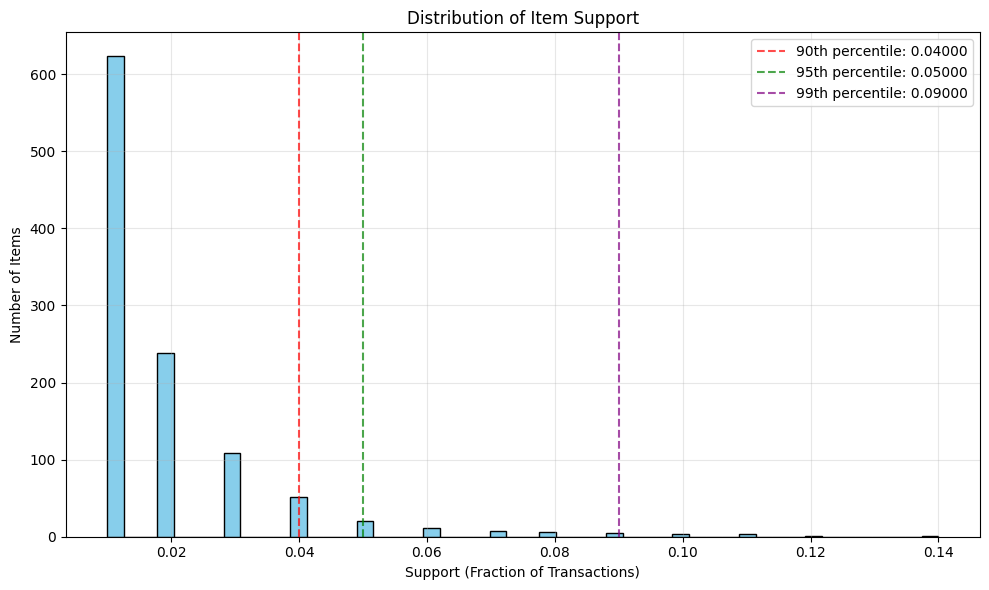


Selected parameters for Apriori algorithm:
min_support: 0.04500 (items must appear in >4.50% of transactions)
min_confidence: 0.20


In [118]:
# First, let's look at the most frequent items
def analyze_item_frequency(transactions):
    # Count item frequencies
    item_counts = Counter()
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1
    
    # Convert to DataFrame for analysis
    item_df = pd.DataFrame({
        'Item': list(item_counts.keys()),
        'Count': list(item_counts.values())
    }).sort_values('Count', ascending=False)
    
    # Calculate support for each item
    total_transactions = len(transactions)
    item_df['Support'] = item_df['Count'] / total_transactions
    
    print(f"Total unique items: {len(item_df)}")
    
    # Display top 15 items
    print("\nTop 15 most frequent items:")
    display(item_df.head(15))
    
    # Plot distribution of item support to help determine a good min_support value
    plt.figure(figsize=(10, 6))
    plt.hist(item_df['Support'], bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Item Support')
    plt.xlabel('Support (Fraction of Transactions)')
    plt.ylabel('Number of Items')
    plt.grid(True, alpha=0.3)
    
    # Calculate potential support thresholds
    support_percentiles = {
        '90th percentile': item_df['Support'].quantile(0.90),
        '95th percentile': item_df['Support'].quantile(0.95),
        '99th percentile': item_df['Support'].quantile(0.99)
    }
    
    # Draw vertical lines for potential support thresholds
    colors = ['red', 'green', 'purple']
    for i, (label, value) in enumerate(support_percentiles.items()):
        plt.axvline(x=value, linestyle='--', color=colors[i], alpha=0.7, 
                   label=f"{label}: {value:.5f}")
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return item_df, support_percentiles

# Analyze item frequency
item_frequency_df, support_percentiles = analyze_item_frequency(transactions)

# Based on the analysis, determine an appropriate min_support value
# Here we'll use a value that keeps items appearing in at least 1% of transactions
min_support = max(0.01, support_percentiles['99th percentile'] * 0.5)
min_confidence = 0.2

print(f"\nSelected parameters for Apriori algorithm:")
print(f"min_support: {min_support:.5f} (items must appear in >{min_support*100:.2f}% of transactions)")
print(f"min_confidence: {min_confidence:.2f}")

In [119]:
# Analyze with Apriori using the UCI Online Retail dataset
print("Applying Apriori algorithm on UCI Online Retail dataset...")
start_time = time.time()
apriori = Apriori(min_support=min_support, min_confidence=min_confidence)
apriori.fit(transactions)
end_time = time.time()

print(f"Apriori completed in {end_time - start_time:.2f} seconds")
    
# Get results
frequent_itemsets = apriori.get_frequent_itemsets()
rules = apriori.get_rules()

print(f"\nFound {len(frequent_itemsets)} frequent itemsets and {len(rules)} association rules")

# Display top frequent itemsets by support
print("\nTop 10 frequent itemsets by support:")
sorted_itemsets = sorted(frequent_itemsets, key=lambda x: x[1], reverse=True)
for i, (itemset, support) in enumerate(sorted_itemsets[:10]):
    items_list = ', '.join(sorted(list(itemset)))
    print(f"{i+1}. {items_list} (support: {support:.4f})")

# Display top rules by confidence
if rules:
    print("\nTop 10 strongest rules by confidence:")
    sorted_by_conf = sorted(rules, key=lambda x: x[2], reverse=True)
    for i, (antecedent, consequent, confidence, lift) in enumerate(sorted_by_conf[:10]):
        ant = ', '.join(sorted(list(antecedent)))
        con = ', '.join(sorted(list(consequent)))
        print(f"{i+1}. {ant} → {con} (confidence: {confidence:.3f}, lift: {lift:.3f})")
    
    # Display top rules by lift
    print("\nTop 10 rules by lift (most interesting associations):")
    sorted_by_lift = sorted(rules, key=lambda x: x[3], reverse=True)
    for i, (antecedent, consequent, confidence, lift) in enumerate(sorted_by_lift[:10]):
        ant = ', '.join(sorted(list(antecedent)))
        con = ', '.join(sorted(list(consequent)))
        print(f"{i+1}. {ant} → {con} (confidence: {confidence:.3f}, lift: {lift:.3f})")
else:
    print("\nNo rules found with the current parameters. Try lowering min_support or min_confidence.")

Applying Apriori algorithm on UCI Online Retail dataset...
Apriori completed in 0.04 seconds

Found 434 frequent itemsets and 7972 association rules

Top 10 frequent itemsets by support:
1. WHITE HANGING HEART T-LIGHT HOLDER (support: 0.1400)
2. RED WOOLLY HOTTIE WHITE HEART. (support: 0.1200)
3. JAM MAKING SET PRINTED (support: 0.1100)
4. HAND WARMER RED RETROSPOT (support: 0.1100)
5. HAND WARMER SCOTTY DOG DESIGN (support: 0.1100)
6. HAND WARMER UNION JACK (support: 0.1100)
7. JUMBO BAG RED RETROSPOT (support: 0.1000)
8. PAPER CHAIN KIT 50'S CHRISTMAS  (support: 0.1000)
9. HAND WARMER OWL DESIGN (support: 0.1000)
10. REGENCY CAKESTAND 3 TIER (support: 0.0900)

Top 10 strongest rules by confidence:
1. CREAM CUPID HEARTS COAT HANGER → KNITTED UNION FLAG HOT WATER BOTTLE (confidence: 1.000, lift: 12.500)
2. CREAM CUPID HEARTS COAT HANGER → SET 7 BABUSHKA NESTING BOXES (confidence: 1.000, lift: 12.500)
3. WHITE METAL LANTERN → KNITTED UNION FLAG HOT WATER BOTTLE (confidence: 1.000, lift:

## 8. Visualizing the Results

Generating visualization of top items...


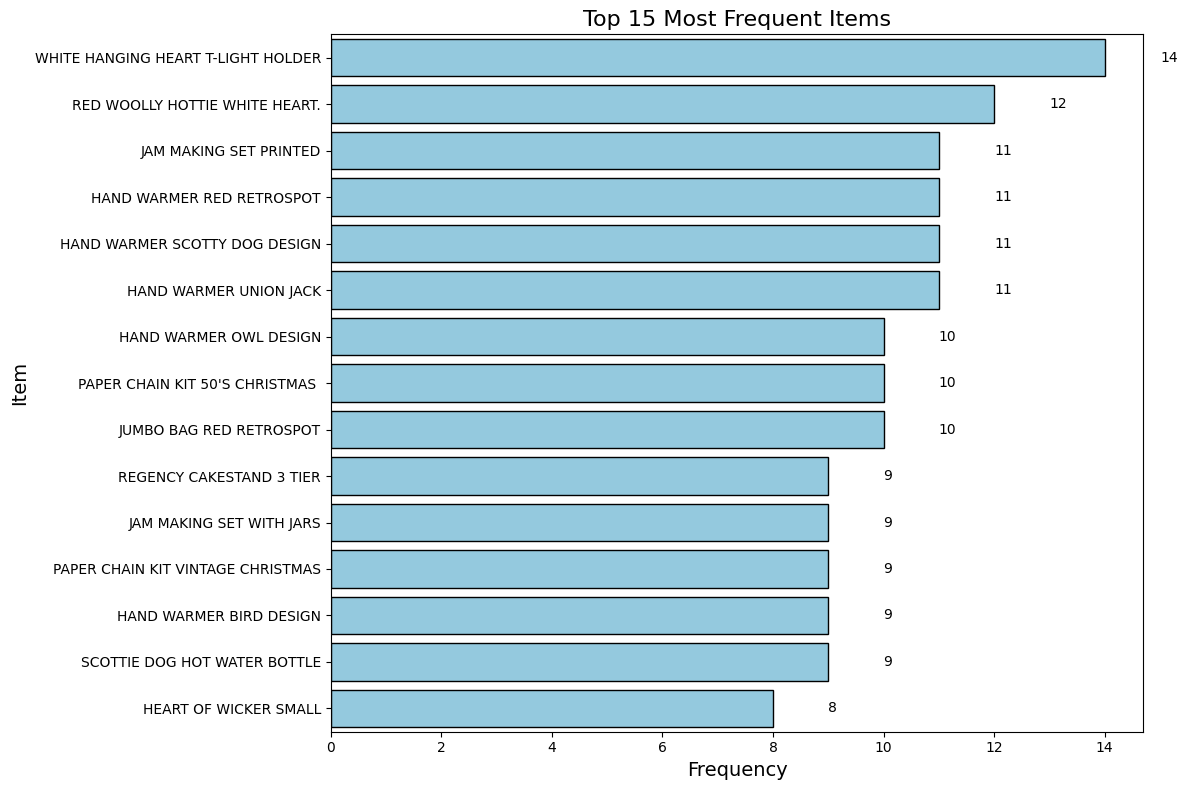

In [120]:
# Create visualizations
print("Generating visualization of top items...")

# Plot item frequency
plot_item_frequency(transactions)

print()